In [1]:
import numpy as np
import h5py 
import pandas as pd

import cv2
import matplotlib.pyplot as plt

def get_positions(fn):
    path = 'runs/'
    with h5py.File(path +fn+'.hdf5', 'r') as f:
        # read the data
        positions = f['x'][:]
        properties = f['properties'][:][0]
        p = f['p'][:]

    return positions



stas = pd.read_csv('Data/tracked_data_rescaled.csv')


# rotate the stas data 45 degrees around y
rot  = 0.055
stas['x_rot'] = stas.x*np.cos(rot) - stas.z*np.sin(rot)
stas['z_rot'] = stas.x*np.sin(rot) + stas.z*np.cos(rot)
stas['y_rot'] = stas.y




# find the stas movement vectors
stas_dirs = -np.ones((len(np.unique(stas.frame)),11000,3))*9999
stas_poss = -np.ones((len(np.unique(stas.frame)),11000,3))*9999
for i, frame in enumerate(np.unique(stas.frame)):
    dirs = np.array([stas[stas.frame == frame].dx, stas[stas.frame == frame].dy, stas[stas.frame == frame].dz]).T

    lens = np.linalg.norm(dirs, axis = 1)
    lens[lens == 0] = 1
    dirs = dirs/lens[:,None]
    
    stas_dirs[i][:len(dirs)] = dirs

    poss = np.array([stas[stas.frame == frame].x_rot, stas[stas.frame == frame].y_rot, stas[stas.frame == frame].z_rot]).T

    stas_poss[i][:len(poss)] = poss


def get_sim_dirs(positions):
        
    sim_step_size = 200

    sim_dirs = np.empty((positions.shape[0]-sim_step_size, positions.shape[1], 3))
    sim_poss = np.empty((positions.shape[0]-sim_step_size, positions.shape[1], 3))  
    for t in range(positions.shape[0]-sim_step_size):
        dir = positions[t+sim_step_size] - positions[t]
        dir = dir/np.linalg.norm(dir, axis = 1)[:,None]
        sim_dirs[t] = dir
        sim_poss[t] = positions[t]

    return sim_poss, sim_dirs


In [2]:
def get_overlappings(fn):
    all_positions = get_positions(fn)

    sim_poss, sim_dirs = get_sim_dirs(all_positions)

    scale = int(sim_poss.shape[0]/100)

    iiis = list(range(0, 25))
    overlaps = np.empty((len(iiis), len(sim_poss[0])))
    avg_compared_dirs = np.empty((len(iiis), len(sim_poss[0]), 3))
    for ind, iii in enumerate(iiis):
        sim_t = iii*scale
        stas_t = iii + 1

        overlap = np.empty((len(sim_poss[sim_t])))
        for cell_id, (pos, dir) in enumerate(zip(sim_poss[sim_t], sim_dirs[sim_t])):
            found = False
            dist = 3
            print(f"{ind/len(iiis):.3}  -  {cell_id/len(sim_poss[sim_t]):.3}", end = "\r")
            while True:
                if dist > 50:
                    print(dist, pos)

                # find the all stas particles within a certain distance
                dists = np.linalg.norm(stas_poss[stas_t] - pos, axis = 1)

                closest = np.where(dists < dist)[0]

                dirs = stas_dirs[stas_t][closest]

                # remove vector if it contains nans
                dirs = dirs[~np.isnan(dirs).any(axis=1)]
                if len(dirs) < 2:
                    dist += 0.1
                    continue
                
                avg_dir = np.mean(dirs, axis = 0)
                avg_compared_dirs[ind][cell_id] = avg_dir

                dot = np.dot(dir, avg_dir)

                break

                    

            # find the angle between the sim dir and the stas dir
            angles = np.arccos(dot)

            overlap[cell_id] = np.mean(angles)
        overlaps[ind] = overlap

    return overlaps

In [27]:
from threading import Thread


def find_and_save(nm):
    print(nm)
    overlaps = get_overlappings(nm)
    np.save("Data/overlaps/" + nm, overlaps)

basename = "finale"
for name in ["_normal", "_nogb", "_noventral", "_nopmg"]:
    for suff in ["2", "3"]:
        fas = lambda : find_and_save(basename + suff+name)
        t = Thread(target = fas)
        t.deamon = True
        t.start()

        



finale2_normal
finale3_normal
finale2_nogb
finale3_nogb
finale2_noventral
finale3_noventral
finale2_nopmg
finale3_nopmg


In [5]:
all_overlaps = {}

basename = "finale"
for name in ["_normal", "_nogb", "_noventral", "_nopmg"]:
    all_overlaps[name] = []
    for suff in ["", "2", "3"]:
        nm = (basename + suff+name)
        all_overlaps[name].append(np.load("Data/overlaps/"+nm+".npy"))
    all_overlaps[name] = np.array(all_overlaps[name])

In [6]:
all_overlaps[name].shape

(3, 40, 5000)

In [41]:
path = 'runs/'

with h5py.File(path +"finale_normal"+'.hdf5', 'r') as f:
    # read the data
    positions = f['x'][:][0]
    properties = f['properties'][:][0]
    p = f['p'][:]



(3, 40, 3001)
(3, 40, 3885)
(3, 40, 4034)
(3, 40, 5000)


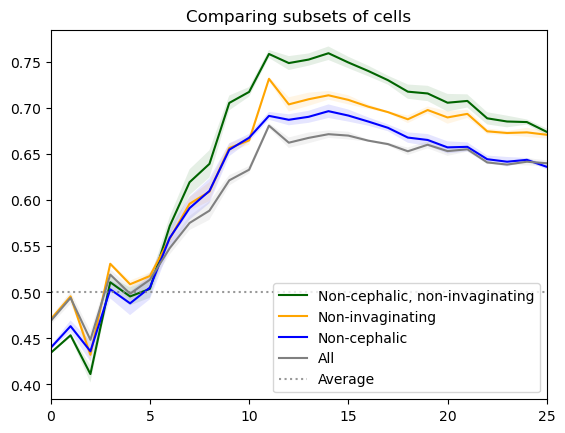

In [200]:

cols = ["darkgreen", "orange", "b", "grey"]
ci = 0

posterior = positions[:,0] > -40
non_invaginating = (properties != 2) 

names = ["All", "Non-cephalic", "Non-invaginating", "Non-cephalic, non-invaginating"][::-1]
for key in all_overlaps:
    if key != "_normal":
        continue

    for cutoff in [np.ones_like(posterior), posterior, non_invaginating, posterior*non_invaginating][::-1]: 
        vals = (1-all_overlaps[key]/np.pi)[:,:,cutoff]
        
        print(vals.shape)
        # m = vals.mean(axis = 0).mean(axis=1)
        m = vals.mean(axis = (0,2))
        # std = vals.std(axis = 0).mean(axis = 1)
        std = vals.mean(axis = 2).std(axis = 0)
    
    
        x = list(range(len(m)))
        plt.fill_between(x, m - std, m+std, alpha = 0.1, facecolor = cols[ci])
        
        plt.plot(vals.mean(axis = 2).mean(axis = 0), '-', label = names[ci], c = cols[ci], )
        # plt.plot(vals.mean(axis = 2).T,  c = cols[ci], alpha = 1.)
        ci += 1

plt.xlim(0,25)
plt.hlines(0.5,0,40,ls =  ":", color = "grey", alpha = 0.8, label = "Average")
plt.title("Comparing subsets of cells")
plt.legend(loc = "lower right")

In [11]:
positions = get_positions("finale_nopmg")[0]

(40, 5000)


<Axes: >

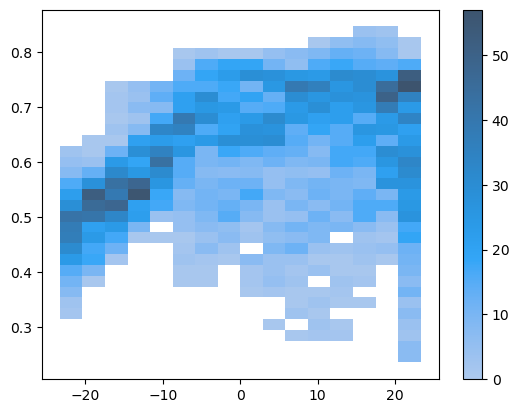

In [83]:
vals = (1-all_overlaps["_normal"]/np.pi)[0]

print(vals.shape)

starboard = positions[:,1] > 0
posterior = positions[:,0] > 0

import seaborn as sns

sns.histplot( x = positions[:,2], y =  vals.mean(axis = 0), cbar = 1)
# plt.plot(vals[:,(~starboard)*posterior].mean(axis = 1))

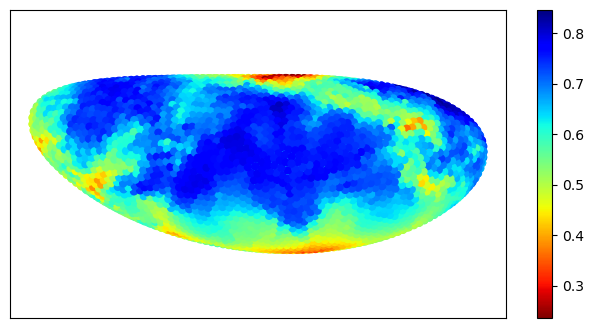

In [226]:
plt.figure(figsize = (8,4))

vals = (1-all_overlaps["_normal"]/np.pi)[0]

sorty = np.argsort(positions[:,1])
p = positions[sorty]
plt.scatter(p[:,0], p[:,2], c = vals[:,sorty].mean(axis = 0), s = 25, cmap = "jet_r")
plt.axis("equal")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
# sorty = np.argsort(positions[:,1])[::-1]
# p = positions[sorty]
# plt.scatter(p[:,0], p[:,2], c = vals[:,sorty].mean(axis = 0), s = 40, cmap = "jet_r")
# plt.axis("equal")

Text(0.5, 0.98, 'Overlap for different runs at different times compared to Posterior Invagination')

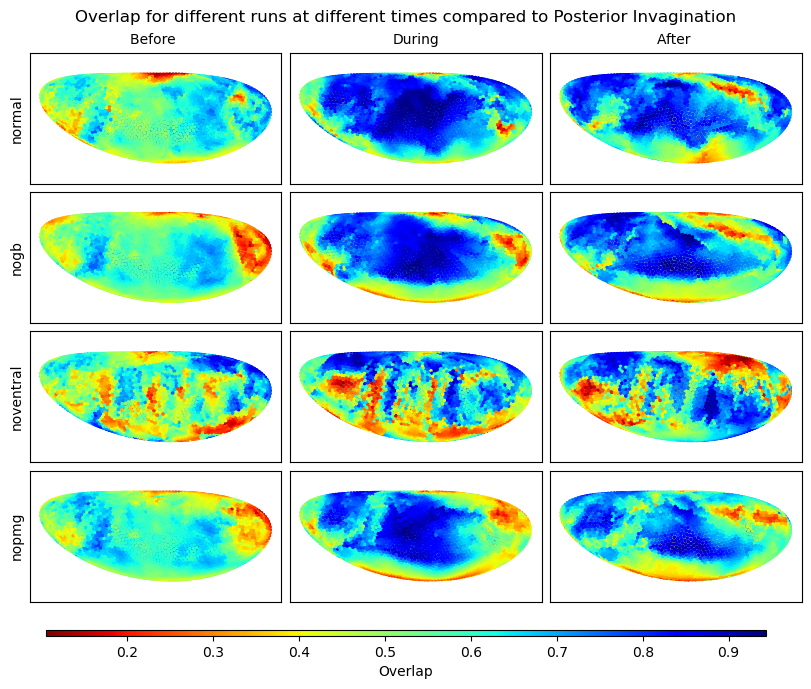

In [197]:
fig, axs = plt.subplots(4,3,height_ratios = [3]*4, figsize = (8, 6), constrained_layout = 1)

sorty = np.argsort(positions[:,1])
p = positions[sorty]

i = 0
titles = ["Before ","During","After "] 
for key in all_overlaps:
    ss = len(vals)//3
    for indx in range(3):
        if i == 0:
            axs[i, indx].set_title(titles[indx], fontsize = 10)
        
        vals = (1-all_overlaps[key]/np.pi)[0]
        scatter = axs[i, indx].scatter(p[:,0], p[:,2], c = vals[indx*ss:(indx+1)*ss,sorty].mean(axis = 0), s = 3, cmap = "jet_r")
        axs[i, indx].axis('equal')
        axs[i, indx].set_xticks([])
        axs[i, indx].set_yticks([])
    axs[i,0].set_ylabel(key[1:])
    i += 1

cbar_ax = fig.add_axes([0.05, -0.05, 0.9, 0.01])
fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal', label = "Overlap")
fig.suptitle("Overlap for different runs at different times compared to Posterior Invagination")
# fig.colorbar(scatter, cax=axs[-1,0], orientation='horizontal', label = "Overlap")

In [ ]:
cluss = {}
for name in ["finale_PSA_l1_",]:
    for suff in ["0", "1", "2", "3", "4", "5"]:
        clus = getclusters(name +suff, scaled = True)
        clus = np.array(clus, dtype = float)
        cluss[name].append(clus)